# Problemas dependientes del tiempo

Nota: a este documento lo podremos ejecutar de manera dinámica si tienen instalado:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).

La visualización del mismo es óptima utilizando Jupyter Notebook.

### Referencias
- Capítulo 5 de Mats G. Larson, Fredrik Bengzon, The Finite Element Method: Theory, Implementation, and Applications. 
- Capítulo 6 de Hans Petter Langtangen and Kent-Andre Mardal, [Introduction to Numerical Methods for Variational Problems](https://www.springer.com/gp/book/9783030237875) (2019), Springer.

## Introducción

La mayoría de los problemas en la vida real son dependientes del tiempo. Por ejemplo, en el problema que veremos en este tutorial aparece un factor dependiente de la derivada de la temperatura respecto del tiempo $\frac{dT}{dt}$. Si la geometría es una barra unidimensional de largo $L$ y la temperatura es la variable que queremos calcular entonces ahora tendremos dependencia de la posición $x$ y del tiempo $t$. Entonces, podemos tomar tres estrategias:

1. Usar primero diferencias finitas para estimar la derivada respecto del tiempo y luego se tendrá el problema de discretización espacial, que lo resolveremos por elementos finitos.
2. Primero discretizar el espacio y luego el tiempo. 
3. Discretizar espacio y tiempo a la vez.

Tomaremos la primer opción. Tal como se estudia habitualmente en la resolución de [ecuaciones diferenciales ordinarias](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_diferencial_ordinaria), existen diferentes opciones para aproximar en diferencias finitas una derivada de primer órden:

- Método de Euler hacia atrás (regresivo, anterior, se puede encontrar de varias maneras, en inglés *backward Euler method*).

$$ \frac{du \left(t_{n}\right)}{dt}=\dot{u}\left(t_{n}\right) \approx \frac{u^{n}-u^{n-1}}{\Delta t} \tag{1}$$

Se llama regresivo porque estamos calculando la derivada del paso $n$ utilizando el mismo paso y el anterior ($n-1$). A este método también se lo denomina *implícito* (ya veremos porque). Lo bueno del método es que es *incondicionalmente estable* (nunca va a crecer de manera indefinida) y $\Delta t$ puede ser elegido arbitrariamente grande (aunque se pierde presición). Es una aproximación de *primer órden*.

- Método de Euler hacia adelante (progresivo, adelantado, en inglés *forward Euler method*).

$$\frac{du \left(t_{n}\right)}{dt}= \dot{u}\left(t_{n}\right) \approx \frac{u^{n+1}-u^{n}}{\Delta t} \tag{2}$$

Note que aquí suponemos que el paso de tiempo es fijo ($\Delta t$) y hemos usado la notación $u^{n}=u\left(t_{n}\right)$. Se llama progresivo porque estamos calculando la derivada del paso $n$ utilizando el mismo paso y el paso futuro ($n+1$). Este método se lo denomina *explícito*. Este método es *condicionalmente estable*, dado que si se elije muy grande el paso puede crecer la solución (además de perder presición). Es también una aproximación de *primer órden*.


Existen otros métodos (ver Apéndice 1 de Langtangen and Mardal, 2019), uno de los más conocidos y más aproximado es el Runge-Kuta, que es un *método explícito de cuarto órden*. Nosotros en el ejemplo siguiente utilizaremos el método de Euler hacia atrás, pero antes, haremos la deducción de la Ecuación del Problema Térmico completa.

### Problema térmico

Tomemos nuevamente el ejemplo de la **temperatura** $T$ en [K] de una barra de longitud $L$ en [m] (1D). Pensemos también que tiene una **fuente** de calor $f$ por unidad de longitud (en [J/sm] es decir [W/m]). También tendremos la **tasa de flujo de calor** $q$ medido en [J/sm$^{2}$] (la energía que fluye por unidad de tiempo por unidad de área, es decir, en [W/m$^{2}$]). A continuación un esquema.

[<img src="barra_termica.png" width="400"/>](barra_termica.png)

Pensemos ahora la energía por unidad de longitud $e$, y su derivada $\dot{e}=\frac{de}{dt}$. La ecuación de balance de energía en toda la barra la lograremos integrando tanto $f$, $\dot{e}$, y sumando la energía que entra y la que sale.

$$\int_{0}^{L} \ \dot{e} \ dx =\underbrace{A\left(0\right)q\left(0\right)}_{\text{Energía que entra}}-\underbrace{A\left(L\right)q\left(L\right)}_{\text{Energía que sale}} +\underbrace{\int_{0}^{L} \ f \ dx.}_{\text{Energía generada}}\tag{3}$$

El Teorema fundamental del cálculo nos da la siguiente expresión:

$$\int_{0}^{L} \ \dot{e} \ dx =-\int_{0}^{L}\left(Aq\right)^{'} \ dx +\int_{0}^{L} \ f \ dx\tag{4}$$

Suponemos también que la energía es proporcional a la temperatura $e=C\cdot T$ (donde $C=\rho \cdot c$ es el producto de la densidad por el calor específico). Si sólamente existe flujo de calor por conducción vale: $ q = - k T^{'}$ donde $k$ es la conductividad térmica. Entonces la Ec. (4) queda:

$$\int_{0}^{L} \ c\rho\frac{dT}{dt} \ dx -\int_{0}^{L}\left(AkT^{'}\right)^{'} \ dx = \int_{0}^{L} \ f \ dx\tag{5}$$

Si hacemos tender a cero $L$, ahora si, llegamos a la Ecuación de calor:

$$ \left \{ \begin{array}{l} c\rho\frac{dT}{dt} -\left(AkT^{'}\right)^{'} =  f  \ \ \text{ para } \ \ x\in I=\left(0,L \right) \text{ es decir en} \Omega \\  \text{condiciones de borde en } \ \partial \Omega \\  \text{y además condiciones iniciales } \ T\left(x,0\right)=T_{0}\left(x\right) \end{array} \tag{6}\right .$$

### Ejemplo 

Ahora resolveremos la Ec. (6) aunque llamaremos $u$ a la variable $T$ y pasamos dividiendo la constante $c\rho$. Nos queda la ecuación:

$$ \left \{ \begin{array}{l} \dot{u} = a\nabla^{2} u +  f  \ \ \text{ para } \ \ x\in I=\left(0,1 \right) \text{ es decir en} \Omega \\ u\left(0,t\right)= u\left(1,t\right)\text{ en } \ \partial \Omega \text{ (Dirichlet) } \\ u\left(x,0\right)=u_{0}\left(x\right) \text{ (condiciones iniciales) } \  \end{array} \tag{7}\right .$$

Note que aquí también hemos supuesto la sección de la barra constante y la conductividad térmica constante con la posición, por eso aparece la derivada segunda respecto de la posición (que la hemos denotado como $\nabla^{2}$). Note que ahora las condiciones de borde dependen del tiempo y las condiciones iniciales dependen de la posición. 

Comenzaremos con la resolución utilizando el Método de Euler hacia atrás (Ec. (1)).

#### Discretización del tiempo

Utilizando las Ecs. (1) y (7) trabajaremos en la discretización primero del tiempo, y luego obtendremos la formulación variacional para discretizar el espacio. Comencemos con algo de notación y la Ec. (7), la ecuación que sigue significa que todas las funciones dentro de los corchetes están evaluadas en el tiempo $t_{n+1}$:

$$ \left[ \dot{u} = a\nabla^{2} u +  f  \right]^{n+1}\tag{8}$$

Note que en el lado izquierdo de la ecuación tenemos la derivada de $u$ evaluada en el tiempo $t_{n+1}$, $\dot{u}\left(t_{n+1}\right)$. Utilizando la Ec. (1), podemos reemplazar esto por su aproximación dada por el Método de Euler hacia atrás:

$$\frac{u^{n+1}-u^{n}}{\Delta t} \approx a\nabla^{2} u^{n+1} +  f^{n+1}$$

entonces podemos despejar:

$$u^{n+1} \approx u^{n}+ \Delta t a\nabla^{2} u^{n+1} + \Delta t f^{n+1} \tag{9}$$

Aclarando un poco, $u_{e}$ es la solución exacta de la Ec. (7) y $u_{e}^{n+1}$ es la solución discretizando el tiempo de la Ec. (9). Es decir, ahora aproximaremos $u_{e}^{n+1}$ por su solución dada por elementos finitos $u^{n+1}$ ($u_{e}^{n+1}\approx u^{n+1}$). 

#### Discretización del espacio

Una vez que tenemos discretizado de alguna manera el tiempo, discretizamos el espacio.

$$u_{e}^{n}\approx u^{n} = \sum_{j=0}^{N}  \mathbf{c}_{j}^{n}\xi_{j}\left(x\right)$$
$$u_{e}^{n+1}\approx u^{n+1} = \sum_{j=0}^{N}  \mathbf{c}_{j}^{n+1}\xi_{j}\left(x\right)$$

donde $N$ son los grados de libertad de discretización espacial y $N_{t}$ es el número de discretización en el tiempo, $\mathbf{c}$ son constantes y $\xi_{j}$ son, por ejemplo, las funciones sombrero que vimos al comienzo de este curso.

#### Formulación variacional

Tomamos la Ec. (9) y multiplicamos por la función de prueba ($v$) e integramos.

$$\int u^{n+1} v \ dx \approx \int \left( u^{n}+ \Delta t a\nabla^{2} u^{n+1} + \Delta t f^{n+1}\right) v \ dx \tag{10}$$

Suponiendo que comenzamos con $u^{0} = u_{0}\left(x\right)$ (condición inicial), entonces al paso siguiente $u^{1}$ lo obtendremos a partir de la Ec. (10). Observamos en esta ecuación que aparece $\nabla^{2} u^{n+1}$ que, como ya lo hemos hablado, tiene derivada de orden dos, por lo tanto debemos reducir el órden. Utilizamos como siempre la fórmula de Green y (suponiendo condiciones de Dirichlet) se tiene:

$$\int u^{n+1} v \ dx \approx \int  u^{n}\cdot v \ dx- \Delta t a \int \nabla u^{n+1} \cdot \nabla v \ dx + \Delta t \int f^{n+1} v \ dx \tag{11}.$$

Todas las integrales son en $\Omega$.

Resolveremos este problema con la solución de un problema teórico para mostrar la presición del método. 

### Código

El código está subido a la carpeta ejemplos y es el archivo *ejemplo14.py*. Es similar al resuelto en el [tutorial de FEniCS](https://fenicsproject.org/pub/tutorial/html/._ftut1006.html#ch:fundamentals:diffusion).

Continuando con el ejemplo anterior, supondremos que $a=1$, y construiremos una función a partir de la Ec. (7), de tal manera que conozcamos la solución exacta. Por ejemplo, supongamos que la solución exacta es:

$$u_{e} = 1+x^{2}+\beta t$$

Calculamos la derivada con respecto al tiempo y da $\frac{du_{e}}{dt}=\beta$. Asimismo, la derivada respecto del espacio da $\frac{\partial^{2}u_{e}}{\partial x^{2}} = 2$, reemplazando este resultado en la Ec. (7) podemos deducir que $f=\beta -2$ y que la condición de Dirichlet en los bordes está dada por $u_{e}\left(0,t\right)=1+\beta t$ y $u_{e}\left(1,t\right)=2+\beta t$. La condición inicial será $u_{0}\left(x\right)=1+x^{2}$.

Entonces podemos comenzar con el código, como siempre, definiendo algunos parámetros (tiempo total de simulación, pasos de simulación, número de intervalos de la malla, etc.), creando la malla y el espacio de la función de prueba ($v$).

In [1]:
from __future__ import print_function
from fenics import *
import numpy as np

T = 10.0            # tiempo final
num_steps = 40     # número de pasos
dt = T / num_steps # paso de tiempo
nx = 20 #numero de intervalos
minx, maxx = 0.0, 1.0 
mesh = IntervalMesh(nx, minx, maxx)#malla en 1D 
V = FunctionSpace(mesh, 'P',1)#Lagrange Finite Element

Luego definiremos la expresión de la solución exacta (que conocemos de antemano, porque la creamos así). Esto me permitirá calcular varias cosas: las condiciones de borde y la condición inicial. Además creándola de esta forma, podremos actualizar su valor fácilmente a medida que evolucione el tiempo.

In [2]:
beta = 1.0
u_D = Expression('1+x[0]*x[0]+beta*t', degree=1, beta=beta, t=0)

Hemos dado el valor de $\beta=1$ (sin perder generalidad). Definimos las condiciones de borde y las condiciones iniciales.

In [3]:
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)#Condición de borde
u_n = interpolate(u_D, V)#Condición inicial

Luego, la función ensayo, la de prueba, y la función $f$ (de acuerdo al razonamiento anterior tiene que valer: $f = \beta -2$)

In [4]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta-2)

Utilizando la Ec. (11) escribimos la formulación variacional de la forma $F=0$:

$$\int u^{n+1} v \ dx - \int  u^{n}\cdot v \ dx + \Delta t a \int \nabla u^{n+1} \cdot \nabla v \ dx - \Delta t \int f^{n+1} v \ dx = 0 \tag{12}.$$

Esto en FEniCS lo escribimos casi textualmente:

In [6]:
F = u*v*dx - u_n*v*dx + dt*dot(grad(u), grad(v))*dx - dt*f*v*dx
a, L = lhs(F), rhs(F)

Hemos reemplazado $u^{n+1}$ por u y $u^{n}$ por u_n.

Ahora tenemos que resolverlo para cada paso de tiempo. Lo hacemos con el siguiente for:

In [8]:
u = Function(V)
u_inter = []
t = 0.0

for nn in range(num_steps):
    # actualiza el tiempo
    t += dt
    u_D.t = t
    # calcula la solución
    solve(a == L, u, bc)
    # Temperatura a la mitad de la barra
    u_inter.append(u(0.5))    
    
    #Calcula errores
    u_exacta = interpolate(u_D,V)
    error = np.abs(u_exacta.vector()-u.vector()).max()
    print('t= %.2f: error = %.3g' %(t,error))
    
    u_n.assign(u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
t= 0.25: error = 8.88e-15
t= 0.50: error = 1.31e-14
t= 0.75: error = 1.6e-14
t= 1.00: error = 1.78e-14
t= 1.25: error = 2e-14
t= 1.50: error = 2.13e-14
t= 1.75: error = 2.35e-14
t= 2.00: error = 2.58e-14
t= 2.25: error = 2.66e-14
t= 2.50: error = 2.98e-14
t= 2.75: error = 3.11e-14
t= 3.00: error = 3.46e-14
t= 3.25: error = 3.55e-14
t= 3.50: error = 3.91e-14
t= 3.75: error = 3.82e-14
t= 4.00: error = 4.17e-14
t= 4.25: error = 4.44e-14
t= 4.50: error = 4.8e-14
t= 4.75: error = 4.8e-14
t= 5.00: error = 5.06e-14
t= 5.25: error = 5.24e-14
t= 5.50: error = 5.15e-14
t= 5.75: error = 5.42e-14
t= 6.00: error = 6.04e-14
t= 6.25: error = 5.95e-14
t= 6.50: error = 6.04e-14
t= 6.75: error = 6.48e-14
t= 7.00: error = 6.75e-14
t= 7.25: error = 6.75e-14
t= 7.50: error = 7.11e-14
t= 7.75: error = 7.46e-14
t= 8.00: error = 7.64e-14
t= 8.25: error = 7.64e-14
t= 8.50: error = 8.17e-14
t= 8.75: error = 7.82e-14
t= 9.00: error = 8.35e-14
t= 9

En cada paso, hemos impreso el error en el cálculo. Luego, podemos dibujar la solución.

Tipo de variable: <class 'dolfin.function.function.Function'>
Cantidad de celdas: 20
Cantidad de vertices: 21


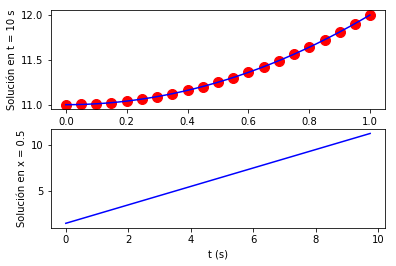

In [11]:
print('Tipo de variable:',type(u))

import matplotlib.pyplot as plt
import numpy as np

#Extraigo los datos de la solucion u.
uh = u.compute_vertex_values(mesh) 

print('Cantidad de celdas:',nx)
print('Cantidad de vertices:',len(uh))

xu = np.linspace(0.0, 1.0, len(uh),endpoint = True)

plt.subplot(2,1,1)
plt.plot(xu,uh,'ro',markersize=10)

##Comparo con solucion exacta
xe = np.arange(0.0,1.0,0.001)
ue = 1.0+xe**2.0+beta*T
plt.plot(xe,ue,'b')
plt.ylabel('Solución en t = 10 s')
plt.xlabel('x')

plt.subplot(2,1,2)
tiempo = np.arange(0.0,T,dt)
plt.plot(tiempo,u_inter,'b')
plt.ylabel('Solución en x = 0.5')
plt.xlabel('t (s)')

plt.show()